In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ugradiolab import Spectrum

HI_FREQ_HZ = 1420.405751768e6  # HI 21-cm rest frequency

DATA_ROOT = os.path.join('..', '..', 'data', 'lab02')
LITE_DIR = os.path.join(DATA_ROOT, 'standard_combined_lite')

long_spectra = sorted(
    [
        Spectrum.load(os.path.join(LITE_DIR, name))
        for name in sorted(os.listdir(LITE_DIR))
        if name.endswith('.npz')
    ],
    key=lambda s: s.center_freq,
)

for s in long_spectra:
    print(f'  LO={s.center_freq/1e6:.0f} MHz   HI offset={(HI_FREQ_HZ - s.center_freq)/1e6:+.3f} MHz')


/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  LO=1420 MHz   HI offset=+0.406 MHz
  LO=1421 MHz   HI offset=-0.594 MHz


# Lab 2.1 Analysis — Bandpass Calibration via Spectral Division

## 1 · The signal chain and the FIR bandpass

The RTL-SDR processes the sky signal in two stages before delivering samples:

**Stage 1 — Downconversion.**  
The local oscillator (LO) at frequency $f_c$ mixes the sky down to baseband, so an astronomical signal at absolute frequency $f$ appears at baseband offset $\Delta f = f - f_c$.

**Stage 2 — FIR decimation filter.**  
The RTL chip applies a fixed finite-impulse-response (FIR) filter $h[n]$ in the time domain before passing samples to the host. In the time domain this is a convolution:

$$x_\text{out}[n] = \bigl(x_\text{in} * h\bigr)[n]$$

By the **convolution theorem**, convolution in time is multiplication in frequency:

$$X_\text{out}(\Delta f) = H(\Delta f) \cdot X_\text{in}(\Delta f)$$

where $H(\Delta f) = \mathcal{F}\{h\}$ is the filter's complex frequency response. The observed power spectral density (PSD) is therefore

$$\boxed{P_\text{obs}(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_c + \Delta f)}$$

The characteristic shape seen in every raw spectrum — high at band centre, rolling off toward the edges — is $\lvert H(\Delta f) \rvert^2$, the **power response of the FIR filter**, not a property of the sky. A polynomial or polynomial-fit baseline removal can approximate this shape but cannot recover it exactly.

---

## 2 · Bandpass calibration by spectral division

Because $\lvert H(\Delta f) \rvert^2$ depends only on baseband offset and the hardware configuration (not on $f_c$), it is **identical** for any two observations taken with the same SDR settings. For two observations at LO frequencies $f_{c,1}$ and $f_{c,2}$:

$$P_1(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,1} + \Delta f)$$
$$P_2(\Delta f) = \lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,2} + \Delta f)$$

Dividing bin-by-bin at the **same baseband index**:

$$R(\Delta f) \;\equiv\; \frac{P_1(\Delta f)}{P_2(\Delta f)} \;=\; \frac{\lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,1} + \Delta f)}{\lvert H(\Delta f) \rvert^2 \cdot S_\text{sky}(f_{c,2} + \Delta f)} \;=\; \frac{S_\text{sky}(f_{c,1} + \Delta f)}{S_\text{sky}(f_{c,2} + \Delta f)}$$

**$\lvert H(\Delta f) \rvert^2$ cancels exactly.** $R(\Delta f)$ is a purely astronomical quantity: the ratio of sky brightness temperatures $\lvert f_{c,2} - f_{c,1} \rvert$ apart, sampled at the baseband grid of the first observation. No knowledge of the filter coefficients is required.

---

## 3 · Application to the 1420 / 1421 MHz pair

The HI 21-cm line sits at $f_\text{HI} = 1420.406$ MHz. The two extreme observations give:

| Observation | $f_c$ | HI position $\Delta f = f_\text{HI} - f_c$ |
|:---|:---:|:---:|
| Signal | 1420 MHz | $+0.406$ MHz |
| Reference | 1421 MHz | $-0.594$ MHz |

Computing $R(\Delta f) = P_{1420}(\Delta f)\;/\;P_{1421}(\Delta f)$:

- **At $\Delta f = +0.406$ MHz** — the 1420 MHz capture contains the HI line; the 1421 MHz capture sees only continuum at that offset → $R > 1$, a **peak**.
- **At $\Delta f = -0.594$ MHz** — the 1420 MHz capture sees continuum; the 1421 MHz capture contains the HI line → $R < 1$, a **dip**.
- **Everywhere else** — both captures see spectrally smooth continuum, so $R \approx 1$.

The pair of features (peak and dip separated by $f_{c,2} - f_{c,1} = 1$ MHz) is a direct signature of a narrow spectral line sitting between the two LO settings. The true line profile can be read from either feature alone.

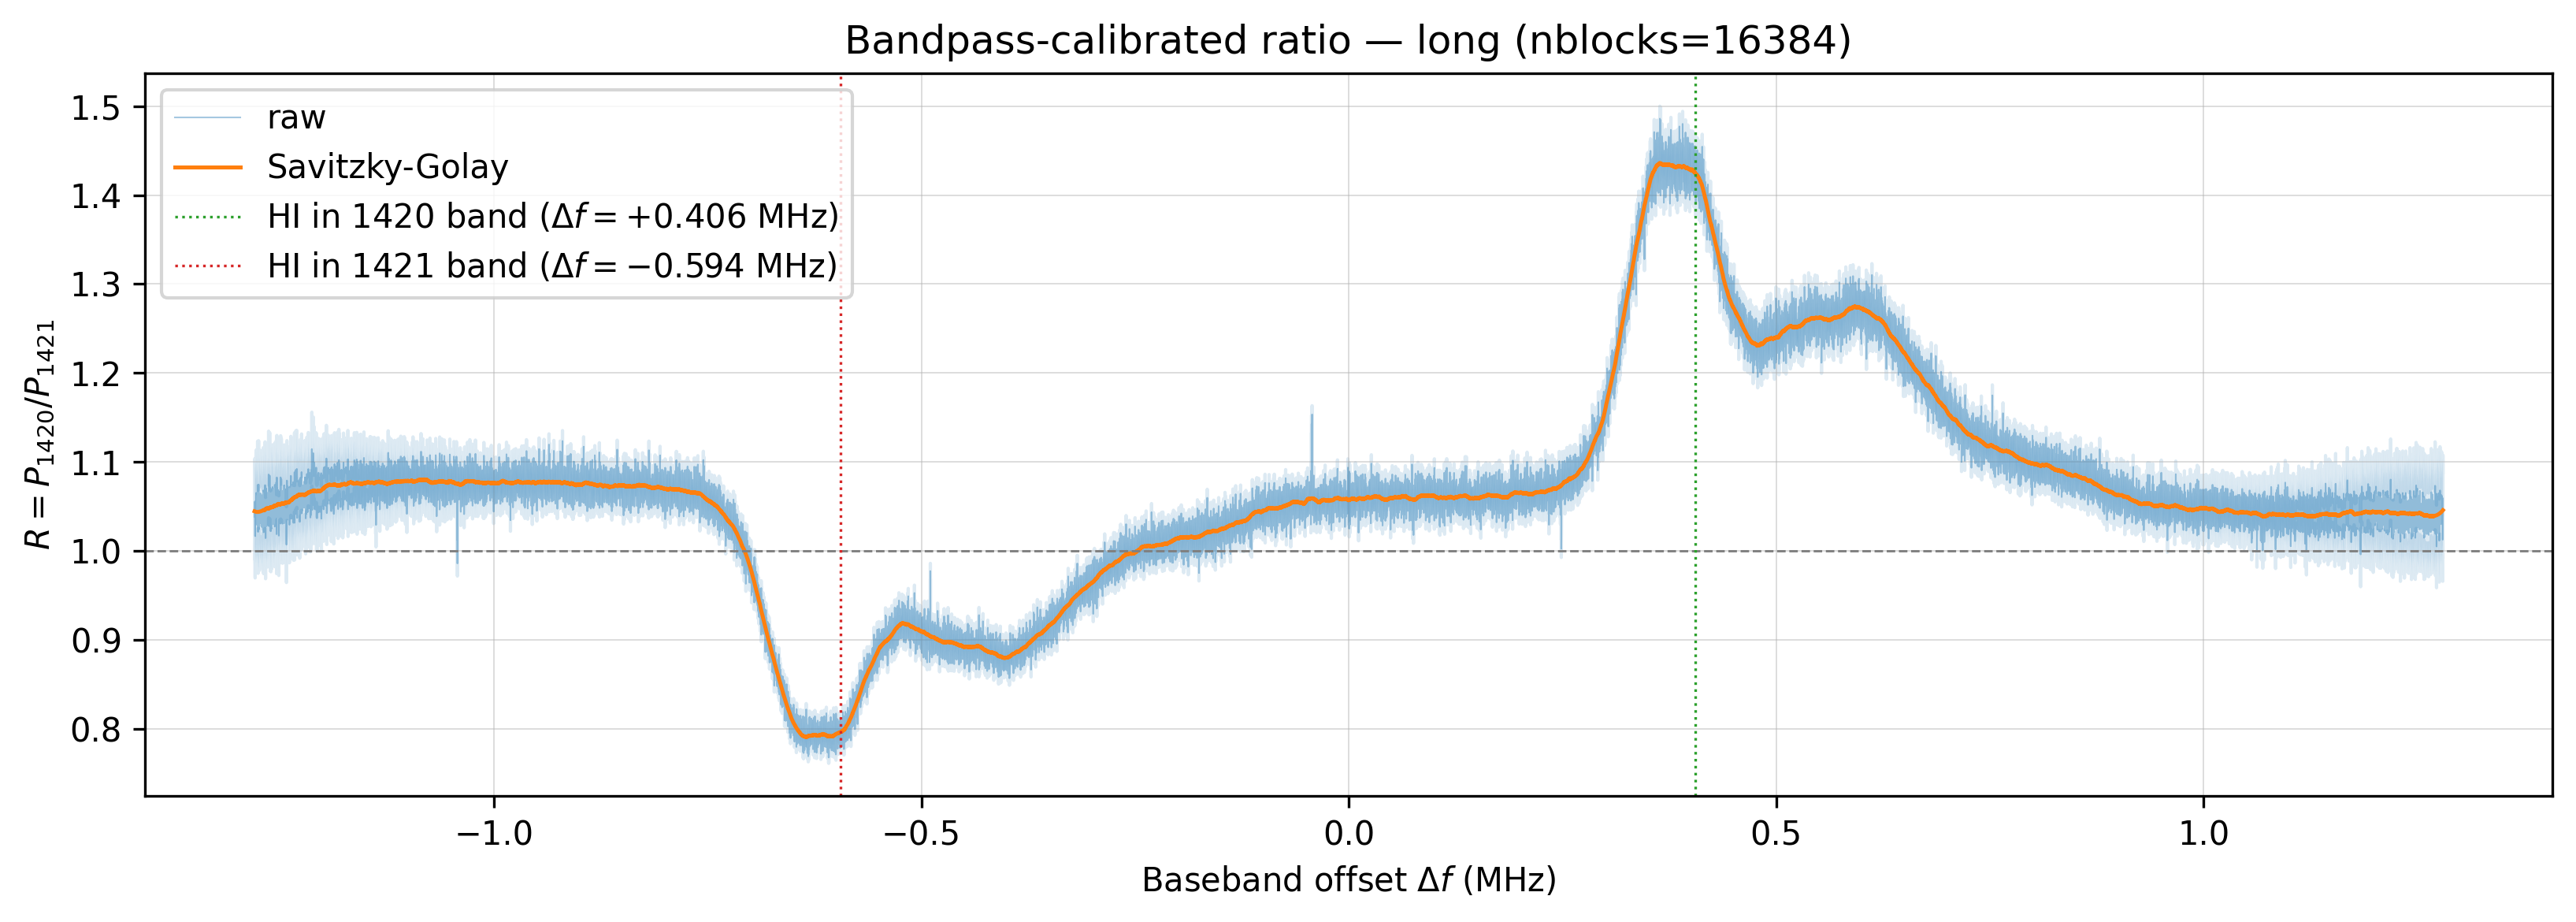

In [2]:
long_1420 = next(s for s in long_spectra if abs(s.center_freq - 1420e6) < 0.5e6)
long_1421 = next(s for s in long_spectra if abs(s.center_freq - 1421e6) < 0.5e6)

baseband_mhz = (long_1420.freqs - long_1420.center_freq) / 1e6

std_1420 = np.asarray(long_1420.std, dtype=float)
std_1421 = np.asarray(long_1421.std, dtype=float)

with np.errstate(divide='ignore', invalid='ignore'):
    R = long_1420.psd / long_1421.psd
    sigma_R = R * np.sqrt((std_1420 / long_1420.psd)**2 + (std_1421 / long_1421.psd)**2)

psd_1420_smooth = long_1420.smooth(method='savgol', window_length=257, polyorder=3)
psd_1421_smooth = long_1421.smooth(method='savgol', window_length=257, polyorder=3)

with np.errstate(divide='ignore', invalid='ignore'):
    R_smooth = psd_1420_smooth / psd_1421_smooth

fig, ax = plt.subplots(figsize=(11, 4), dpi=300)
ax.fill_between(baseband_mhz, R - sigma_R, R + sigma_R, alpha=0.15, color='C0')
ax.plot(baseband_mhz, R,        lw=0.5, alpha=0.4, color='C0', label='raw')
ax.plot(baseband_mhz, R_smooth, lw=1.2,             color='C1', label='Savitzky-Golay')
ax.axhline(1.0, color='gray', lw=0.7, linestyle='--')
ax.axvline((HI_FREQ_HZ - 1420e6) / 1e6, color='C2', lw=0.8, linestyle=':',
           label=fr'HI in 1420 band ($\Delta f = {(HI_FREQ_HZ - 1420e6)/1e6:+.3f}$ MHz)')
ax.axvline((HI_FREQ_HZ - 1421e6) / 1e6, color='C3',    lw=0.8, linestyle=':',
           label=fr'HI in 1421 band ($\Delta f = {(HI_FREQ_HZ - 1421e6)/1e6:+.3f}$ MHz)')
ax.set_xlabel(r'Baseband offset $\Delta f$ (MHz)')
ax.set_ylabel(r'$R = P_{1420} / P_{1421}$')
ax.set_title(fr'Bandpass-calibrated ratio — long (nblocks={long_1420.nblocks})')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

In [3]:
import ugradio.doppler

# For zenith pointing: RA = LST, Dec = observer latitude.
# ugradio.timing.lst stores LST in radians; convert to degrees for get_projected_velocity.
ra_deg  = np.degrees(long_1420.lst)
dec_deg = long_1420.obs_lat      # zenith: Dec = geographic latitude

v_lsr_ms = ugradio.doppler.get_projected_velocity(
    ra=ra_deg,
    dec=dec_deg,
    jd=long_1420.jd,
    obs_lat=long_1420.obs_lat,
    obs_lon=long_1420.obs_lon,
    obs_alt=long_1420.obs_alt,
)
v_lsr_kms = v_lsr_ms / 1e3   # m/s → km/s

print(f'Zenith pointing:  RA = {ra_deg:.3f}°   Dec = {dec_deg:.3f}°')
print(f'JD of observation: {long_1420.jd:.5f}')
print(f'LSR correction (v_projected): {v_lsr_kms:+.4f} km/s')
print(f'  v_LSR = v_topo + ({v_lsr_kms:+.4f} km/s)')


Zenith pointing:  RA = 19.023°   Dec = 37.873°
JD of observation: 2461094.46780
LSR correction (v_projected): -23.0045 km/s
  v_LSR = v_topo + (-23.0045 km/s)


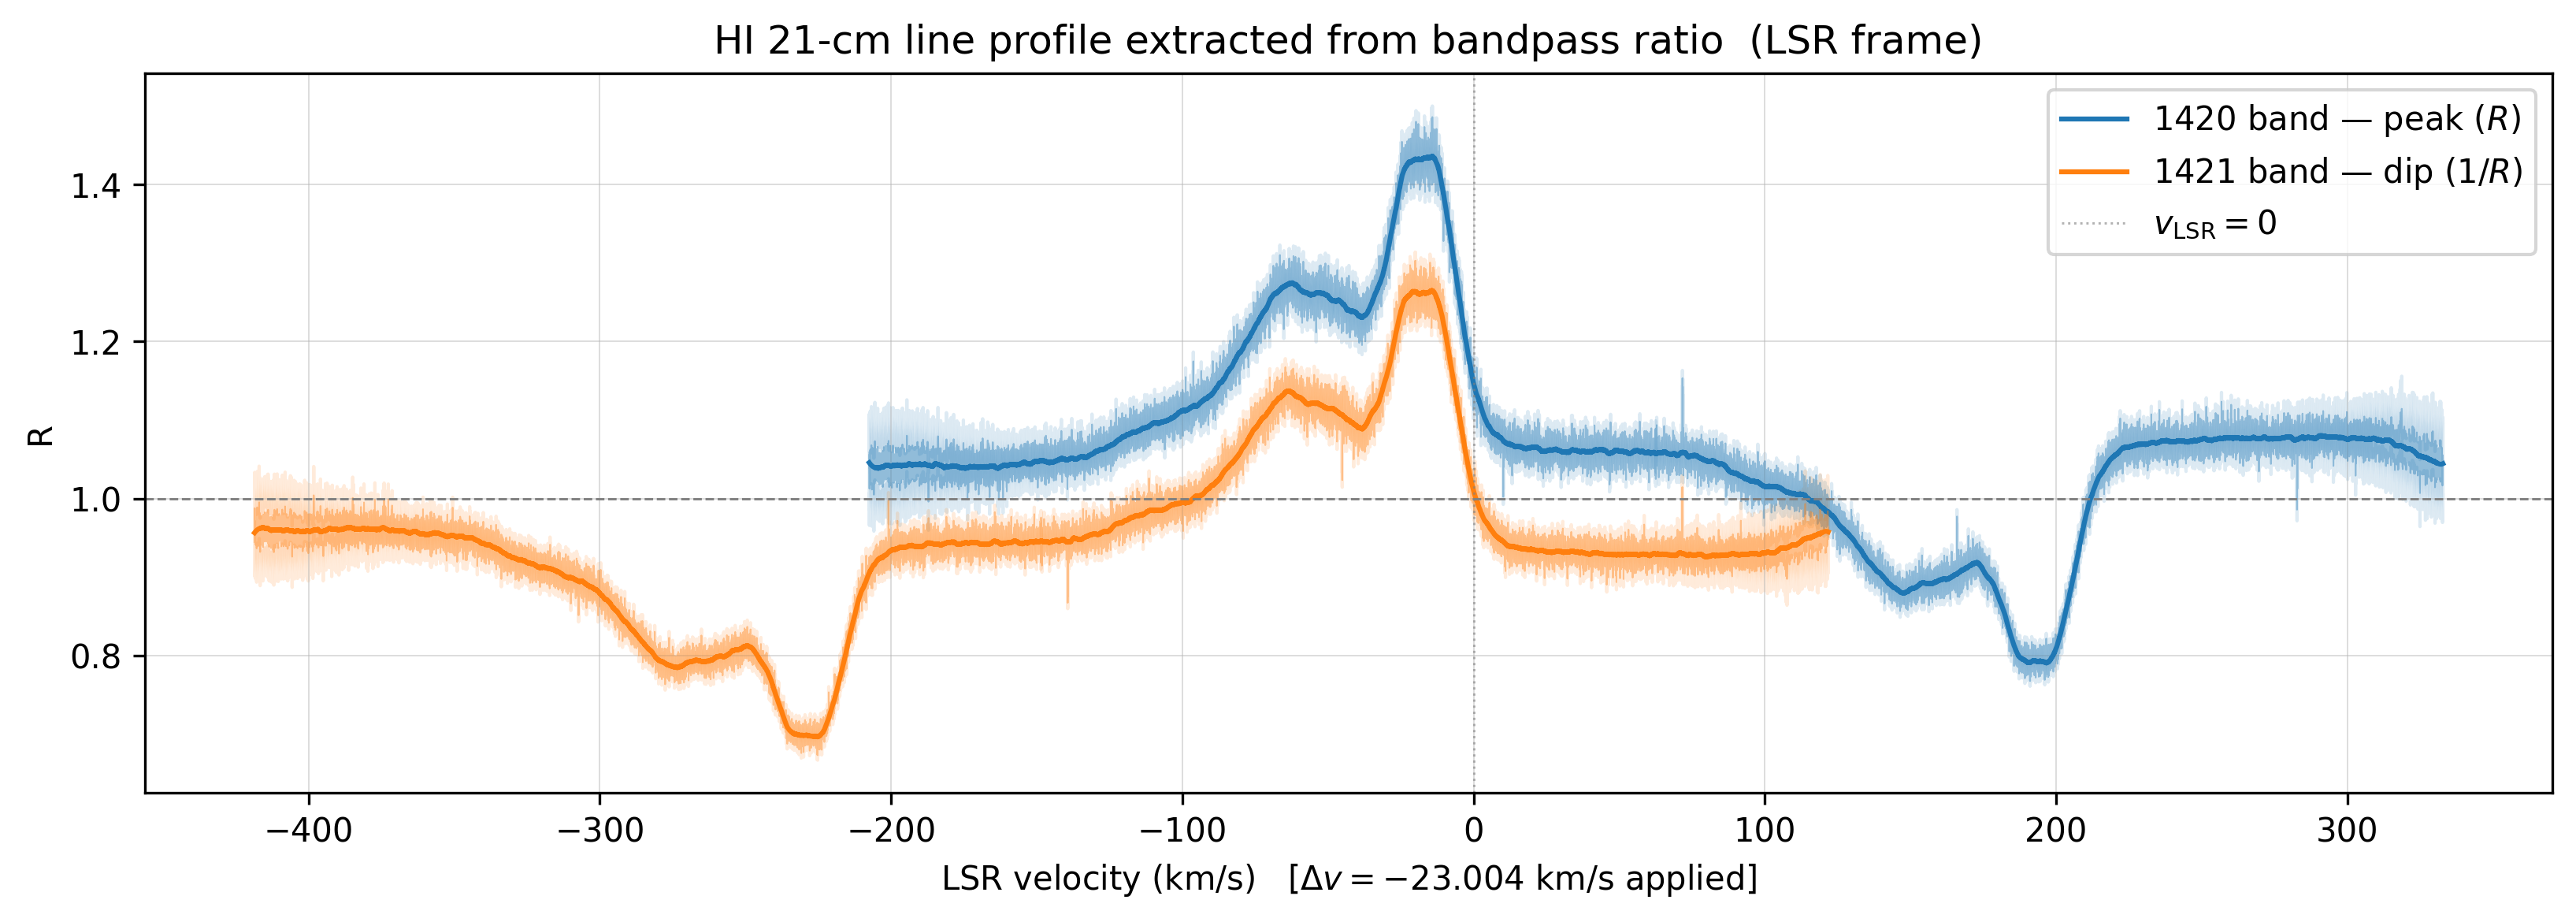

In [4]:
C_LIGHT_MPS = 2.99792458e8  # m/s

# Topocentric velocities shifted to LSR frame
vel_1420 = C_LIGHT_MPS * (HI_FREQ_HZ - long_1420.freqs) / HI_FREQ_HZ / 1e3 + v_lsr_kms  # km/s LSR
vel_1421 = C_LIGHT_MPS * (HI_FREQ_HZ - long_1421.freqs) / HI_FREQ_HZ / 1e3 + v_lsr_kms  # km/s LSR

profile_peak       = R - 1
sigma_peak         = sigma_R

with np.errstate(divide='ignore', invalid='ignore'):
    profile_dip    = 1.0 / R - 1
    sigma_dip      = sigma_R / R**2  # error propagation through 1/R

profile_peak_smooth = R_smooth - 1
with np.errstate(divide='ignore', invalid='ignore'):
    profile_dip_smooth = 1.0 / R_smooth - 1

fig, ax = plt.subplots(figsize=(11, 4), dpi=300)

ax.fill_between(vel_1420,
                (profile_peak - sigma_peak + 1),
                (profile_peak + sigma_peak + 1),
                alpha=0.15, color='C0')
ax.plot(vel_1420, profile_peak + 1,
        lw=0.5, alpha=0.4, color='C0')
ax.plot(vel_1420, profile_peak_smooth + 1,
        lw=1.5, color='C0', label=r'1420 band — peak ($R$)')

ax.fill_between(vel_1421,
                (profile_dip - sigma_dip + 1),
                (profile_dip + sigma_dip + 1),
                alpha=0.15, color='C1')
ax.plot(vel_1421, profile_dip + 1,
        lw=0.5, alpha=0.4, color='C1')
ax.plot(vel_1421, profile_dip_smooth + 1,
        lw=1.5, color='C1', label=r'1421 band — dip ($1/R$)')

ax.axhline(1,  color='gray', lw=0.7, linestyle='--')
ax.axvline(0,  color='gray', lw=0.7, linestyle=':', alpha=0.6, label=r'$v_\mathrm{LSR}=0$')
ax.set_xlabel(f'LSR velocity (km/s)   [$\\Delta v = {v_lsr_kms:+.3f}$ km/s applied]')
ax.set_ylabel('R')
ax.set_title('HI 21-cm line profile extracted from bandpass ratio  (LSR frame)')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()


## 4 · Gaussian Decomposition of the HI Line Profile

We fit a sum of $N$ Gaussians to both the **1420-band peak** ($R - 1$) and the **1421-band dip** ($1/R - 1$) profiles.

A single Gaussian component is

$$
G_k(v) = A_k\,\exp\!\left[-\frac{(v - v_{0,k})^2}{2\sigma_k^2}\right],
$$

where $A_k$ is amplitude, $v_{0,k}$ is centroid velocity (km s$^{-1}$), and $\sigma_k$ is width (km s$^{-1}$).
The full line model is

$$
P_{\mathrm{model}}(v) = \sum_{k=1}^{N} G_k(v) + \sum_{m=0}^{M} c_m\left(\frac{v}{100}\right)^m,
$$

with the second term representing a low-order polynomial baseline.
The FWHM of each Gaussian is

$$
\mathrm{FWHM}_k = 2\sqrt{2\ln 2}\,\sigma_k.
$$

To account for broad residual structure in the ratio spectrum, we fit the Gaussians together with a low-order polynomial baseline over a restricted velocity window. Fits are performed with `scipy.optimize.curve_fit` using per-channel uncertainties propagated from `Spectrum.std`.


In [5]:
from scipy.optimize import curve_fit

C_LIGHT_KMS = 2.99792458e5  # km/s
vel_1420_kms = C_LIGHT_KMS * (HI_FREQ_HZ - long_1420.freqs) / HI_FREQ_HZ
vel_1421_kms = C_LIGHT_KMS * (HI_FREQ_HZ - long_1421.freqs) / HI_FREQ_HZ

FWHM_FACTOR = 2.0 * np.sqrt(2.0 * np.log(2.0))

# ---------------------------------------------------------------------------
# Velocity window to fit within (km/s).
# ---------------------------------------------------------------------------
VEL_FIT_MIN = -120.0
VEL_FIT_MAX = +120.0

# Polynomial order for the additive baseline in profile space.
# 0 = constant offset, 1 = offset + slope, 2 = quadratic, etc.
BASELINE_POLY_ORDER = 1

# ---------------------------------------------------------------------------
# Initial guesses: list of (amplitude, centre_kms, sigma_kms) per component.
# Amplitudes are in units of (R - 1) — fractional excess above the continuum.
# Add or remove tuples to change the number of Gaussian components.
# ---------------------------------------------------------------------------
INITIAL_GUESSES = [
    (0.25,   5.0, 10.0),
    (0.18, -35.0, 25.0),
]


def multi_gaussian(v, *params):
    """Sum of N Gaussians. params = [A1, v1, sig1, A2, v2, sig2, ...]"""
    result = np.zeros_like(v, dtype=float)
    for i in range(len(params) // 3):
        A, v0, s = params[3 * i], params[3 * i + 1], params[3 * i + 2]
        result += A * np.exp(-0.5 * ((v - v0) / s) ** 2)
    return result


def baseline_poly(v, *coeffs):
    """Polynomial baseline in x = v/100 (for numerically stable coefficients)."""
    x = v / 100.0
    result = np.zeros_like(v, dtype=float)
    for i, c in enumerate(coeffs):
        result += c * x**i
    return result


def profile_model(v, *params):
    """Gaussian mixture + polynomial baseline."""
    n = len(INITIAL_GUESSES)
    gauss_params = params[: 3 * n]
    base_params  = params[3 * n :]
    return multi_gaussian(v, *gauss_params) + baseline_poly(v, *base_params)


def fit_profile(vel_kms, profile_raw, sigma_profile, label=''):
    """Fit Gaussian components + polynomial baseline to the RAW profile.

    Returns popt, perr, mask, chi2_red.
    """
    mask = (
        np.isfinite(vel_kms)
        & np.isfinite(profile_raw)
        & np.isfinite(sigma_profile)
        & (sigma_profile > 0)
        & (vel_kms >= VEL_FIT_MIN)
        & (vel_kms <= VEL_FIT_MAX)
    )
    v_fit = vel_kms[mask]
    p_fit = profile_raw[mask]
    s_fit = sigma_profile[mask]

    n = len(INITIAL_GUESSES)
    n_base = BASELINE_POLY_ORDER + 1

    # Gaussian starting point
    p0_gauss = [x for tup in INITIAL_GUESSES for x in tup]

    # Baseline starting point from line-free channels in the same fit window
    outer = np.abs(v_fit) > 80.0
    if outer.sum() <= BASELINE_POLY_ORDER:
        outer = np.ones_like(v_fit, dtype=bool)
    coeff_high_to_low = np.polyfit(
        v_fit[outer] / 100.0,
        p_fit[outer],
        deg=BASELINE_POLY_ORDER,
        w=1.0 / np.maximum(s_fit[outer], 1e-9),
    )
    p0_base = coeff_high_to_low[::-1].tolist()  # convert to [c0, c1, ...]

    p0 = p0_gauss + p0_base

    lower_gauss = [0.0, -200.0, 1.0] * n
    upper_gauss = [np.inf, 200.0, 200.0] * n
    lower_base = [-np.inf] * n_base
    upper_base = [np.inf] * n_base

    popt, pcov = curve_fit(
        profile_model,
        v_fit,
        p_fit,
        p0=p0,
        sigma=s_fit,
        absolute_sigma=True,
        bounds=(lower_gauss + lower_base, upper_gauss + upper_base),
        maxfev=50000,
    )
    perr = np.sqrt(np.diag(pcov))

    residuals = p_fit - profile_model(v_fit, *popt)
    n_params = 3 * n + n_base
    chi2_red = np.sum((residuals / s_fit) ** 2) / max(mask.sum() - n_params, 1)

    print(f'\n{label}  ({n}-component fit + poly{BASELINE_POLY_ORDER}, {mask.sum()} channels, χ²_r = {chi2_red:.3f})')
    print(f'  {"Comp":>4}  {"A":>10}  {"v0_topo (km/s)":>15}  {"sigma (km/s)":>13}  {"FWHM (km/s)":>12}')
    print(f'  {"-"*4}  {"-"*10}  {"-"*15}  {"-"*13}  {"-"*12}')
    for i in range(n):
        A, v0, s = popt[3 * i], popt[3 * i + 1], popt[3 * i + 2]
        dA, dv0, ds = perr[3 * i], perr[3 * i + 1], perr[3 * i + 2]
        fwhm, dfwhm = FWHM_FACTOR * s, FWHM_FACTOR * ds
        print(
            f'  {i+1:>4}  {A:>8.5f}±{dA:<8.5f}  '
            f'{v0:>+12.2f}±{dv0:<7.2f}  '
            f'{s:>10.2f}±{ds:<7.2f}  '
            f'{fwhm:>9.2f}±{dfwhm:<7.2f}'
        )

    base_start = 3 * n
    for i in range(n_base):
        c = popt[base_start + i]
        dc = perr[base_start + i]
        print(f'  baseline c{i}: {c:+.6f} ± {dc:.6f}  (x = v/100)')

    return popt, perr, mask, chi2_red


# Fit the RAW (unsmoothed) ratio profiles so that sigma values are consistent
popt_peak, perr_peak, mask_peak, chi2r_peak = fit_profile(
    vel_1420_kms,
    profile_peak,
    sigma_peak,
    label='1420-band (peak, R - 1)',
)

popt_dip, perr_dip, mask_dip, chi2r_dip = fit_profile(
    vel_1421_kms,
    profile_dip,
    sigma_dip,
    label='1421-band (dip, 1/R - 1)',
)

# --- LSR-corrected centroid velocities ---
print(f'\nLSR correction: Δv = {v_lsr_kms:+.4f} km/s  (v_LSR = v_topo + Δv)')
print(f'  {"Band":<12}  {"Comp":>4}  {"v0_topo (km/s)":>16}  {"v0_LSR (km/s)":>15}')
print(f'  {"-"*12}  {"-"*4}  {"-"*16}  {"-"*15}')
for band_label, popt_arr, perr_arr in [
    ('1420-band', popt_peak, perr_peak),
    ('1421-band', popt_dip,  perr_dip),
]:
    for i in range(len(INITIAL_GUESSES)):
        v0_topo = popt_arr[3 * i + 1]
        v0_lsr  = v0_topo + v_lsr_kms
        dv0     = perr_arr[3 * i + 1]
        print(f'  {band_label:<12}  {i+1:>4}  {v0_topo:>+13.2f}±{dv0:<5.2f}  {v0_lsr:>+12.2f}±{dv0:<5.2f}')



1420-band (peak, R - 1)  (2-component fit + poly1, 14554 channels, χ²_r = 1.996)
  Comp           A   v0_topo (km/s)   sigma (km/s)   FWHM (km/s)
  ----  ----------  ---------------  -------------  ------------
     1   0.35530±0.00073          +6.33±0.02          10.13±0.02         23.85±0.05   
     2   0.20578±0.00034         -34.99±0.07          22.58±0.08         53.17±0.20   
  baseline c0: +0.060058 ± 0.000154  (x = v/100)
  baseline c1: -0.009031 ± 0.000177  (x = v/100)

1421-band (dip, 1/R - 1)  (2-component fit + poly1, 14555 channels, χ²_r = 1.843)
  Comp           A   v0_topo (km/s)   sigma (km/s)   FWHM (km/s)
  ----  ----------  ---------------  -------------  ------------
     1   0.30161±0.00062          +6.34±0.02           9.88±0.02         23.26±0.05   
     2   0.18115±0.00027         -35.19±0.07          24.02±0.08         56.56±0.20   
  baseline c0: -0.060067 ± 0.000132  (x = v/100)
  baseline c1: -0.014769 ± 0.000156  (x = v/100)

LSR correction: Δv = -23.0045 

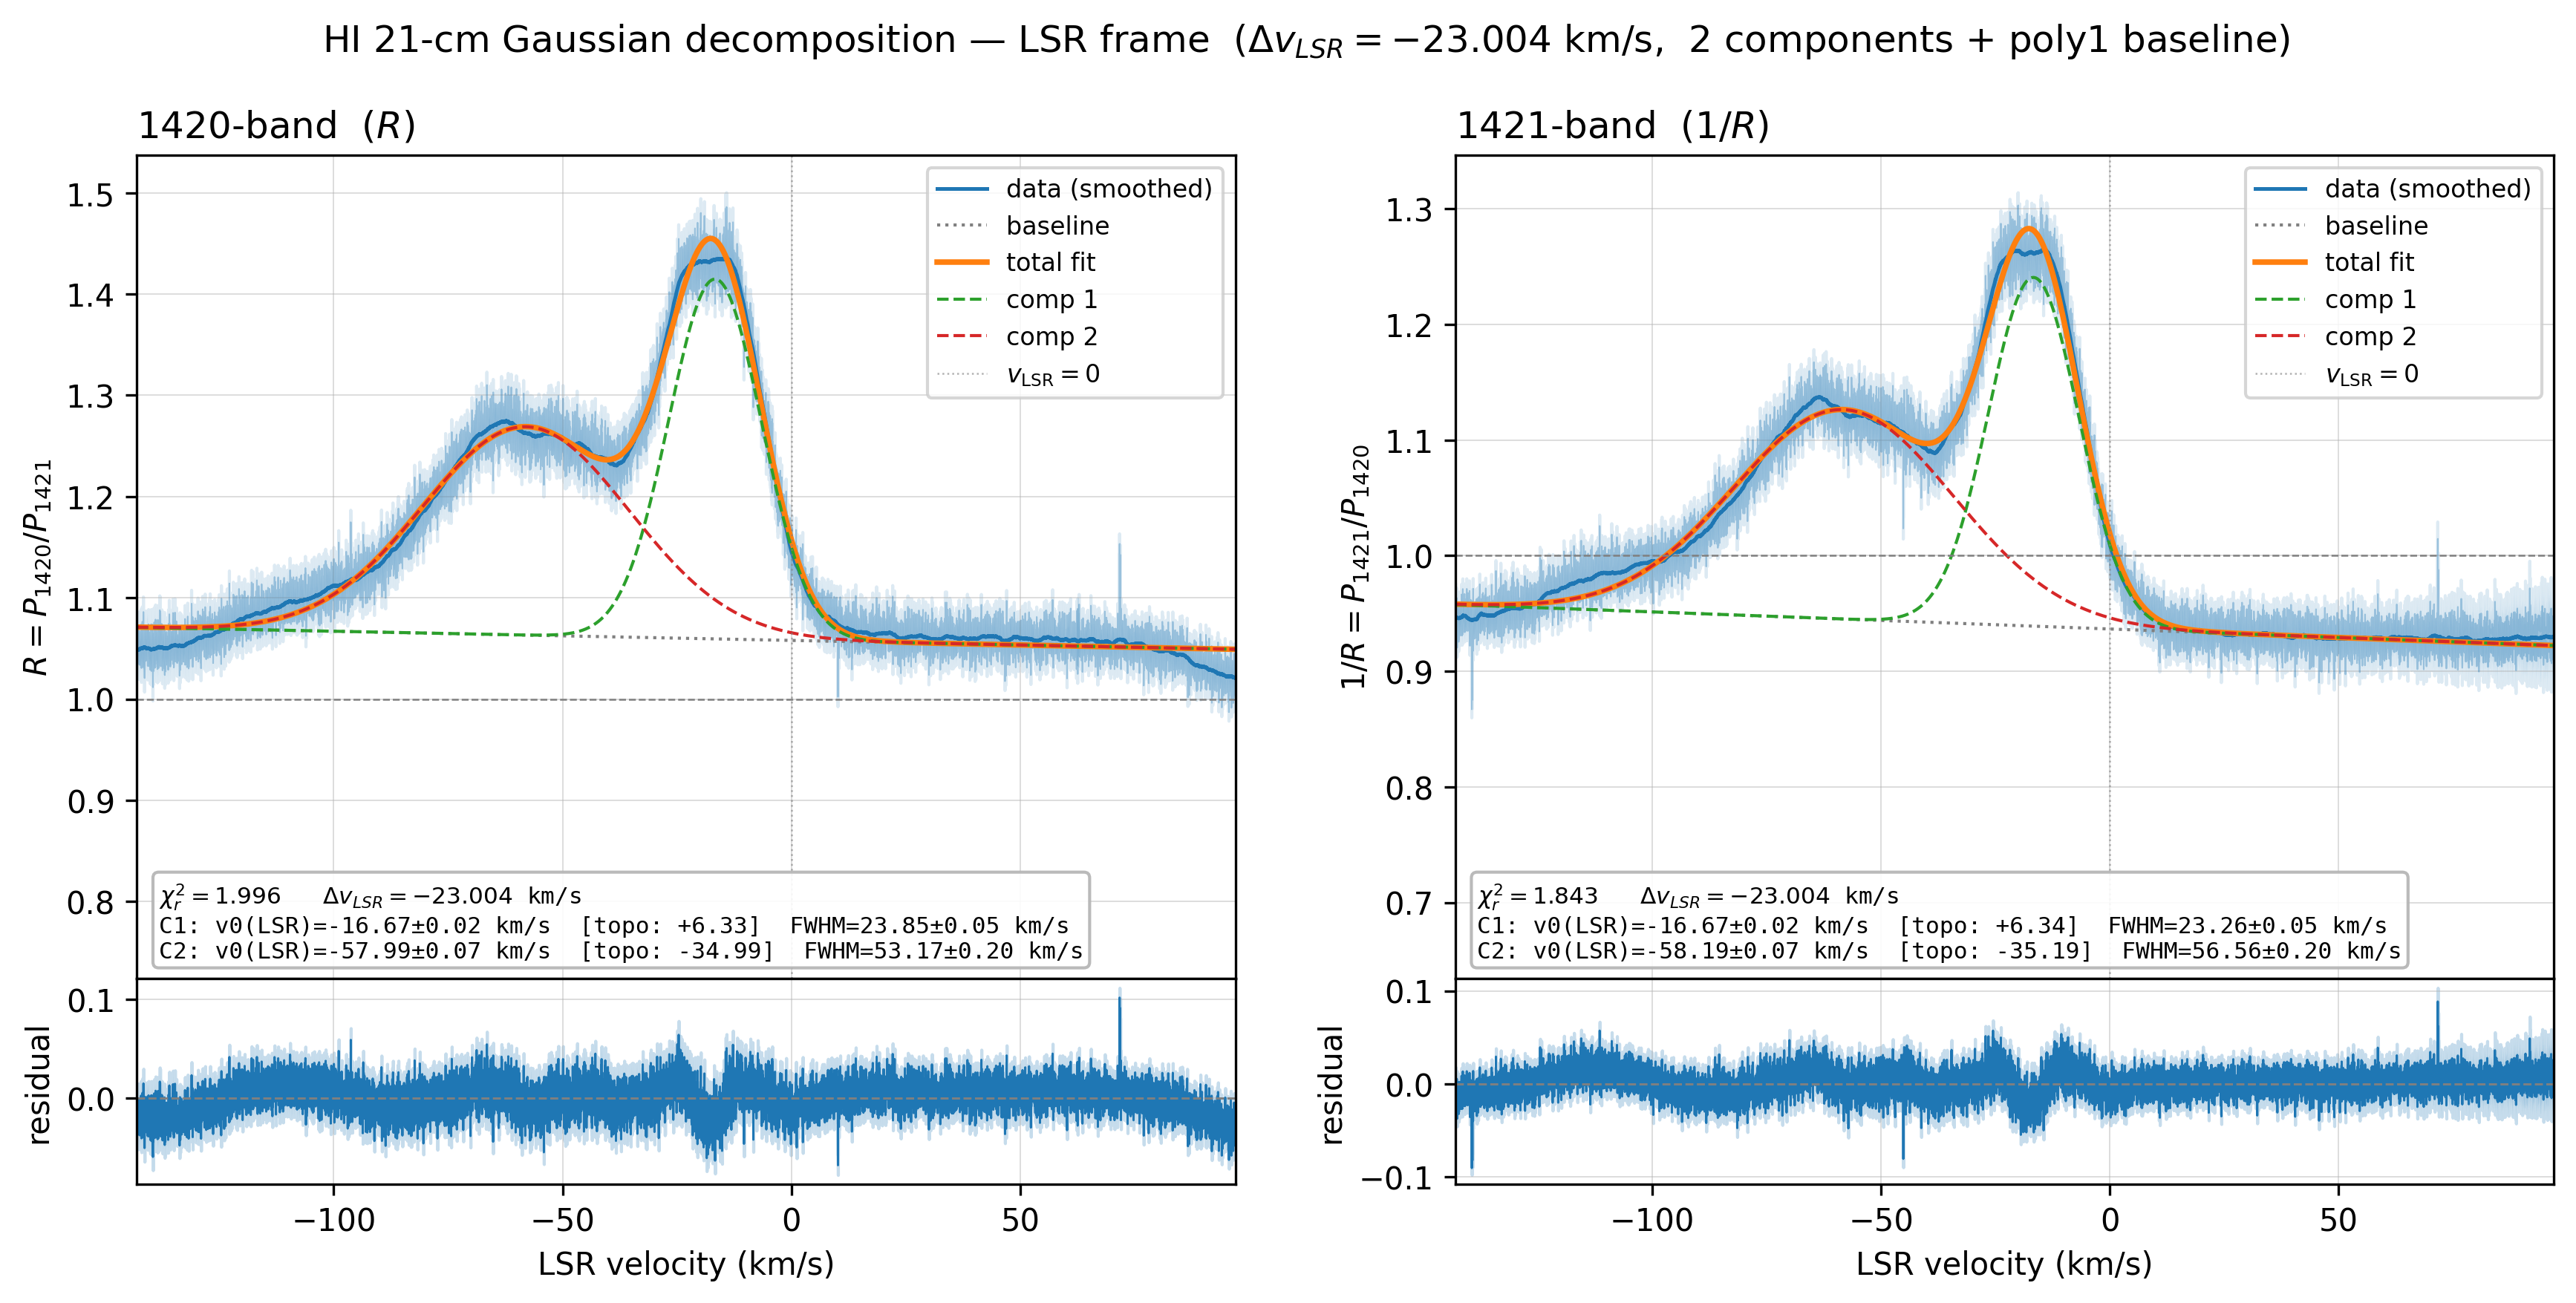

In [6]:
v_grid     = np.linspace(VEL_FIT_MIN, VEL_FIT_MAX, 4000)
v_grid_lsr = v_grid + v_lsr_kms          # same grid shifted to LSR frame

n_comp = len(INITIAL_GUESSES)
n_base = BASELINE_POLY_ORDER + 1
comp_colors = [f'C{i + 2}' for i in range(n_comp)]

fig, axes = plt.subplots(
    2,
    2,
    figsize=(14, 6),
    dpi=300,
    gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.0},
    sharex='col',
)

bands = [
    (vel_1420_kms, profile_peak, sigma_peak, profile_peak_smooth, mask_peak, popt_peak, perr_peak, chi2r_peak, '1420-band  ($R$)',   r'$R = P_{1420}/P_{1421}$'),
    (vel_1421_kms, profile_dip,  sigma_dip,  profile_dip_smooth,  mask_dip,  popt_dip,  perr_dip,  chi2r_dip,  '1421-band  ($1/R$)', r'$1/R = P_{1421}/P_{1420}$'),
]

for col, (vel_kms, prof_raw, sigma_prof, prof_smooth, mask, popt, perr, chi2r, band_label, ylabel) in enumerate(bands):
    ax_main = axes[0, col]
    ax_res  = axes[1, col]

    vel_lsr = vel_kms + v_lsr_kms         # topocentric → LSR for display

    fit_curve = profile_model(v_grid, *popt)
    baseline  = baseline_poly(v_grid, *popt[3 * n_comp : 3 * n_comp + n_base])

    # Data (plotted on LSR axis)
    ax_main.fill_between(
        vel_lsr,
        prof_raw + 1 - sigma_prof,
        prof_raw + 1 + sigma_prof,
        alpha=0.15,
        color='C0',
    )
    ax_main.plot(vel_lsr, prof_raw + 1,    lw=0.5, alpha=0.35, color='C0')
    ax_main.plot(vel_lsr, prof_smooth + 1, lw=1.2, color='C0', label='data (smoothed)')

    # Baseline + fit model (evaluated in topo frame, displayed on LSR axis)
    ax_main.plot(v_grid_lsr, baseline + 1,    lw=1.0, ls=':', color='gray', label='baseline')
    ax_main.plot(v_grid_lsr, fit_curve + 1,   lw=1.8, color='C1',           label='total fit')

    # Individual components on top of baseline
    for i in range(n_comp):
        comp = multi_gaussian(v_grid, popt[3 * i], popt[3 * i + 1], popt[3 * i + 2])
        ax_main.plot(v_grid_lsr, baseline + comp + 1, lw=1.0, ls='--', color=comp_colors[i], label=f'comp {i + 1}')

    # Annotation: LSR centroids + applied shift
    summary_lines = [
        fr'$\chi^2_r={chi2r:.3f}$   $\Delta v_{{LSR}}={v_lsr_kms:+.3f}$ km/s',
    ]
    for i in range(n_comp):
        v0_topo = popt[3 * i + 1]
        s       = popt[3 * i + 2]
        dv0     = perr[3 * i + 1]
        ds      = perr[3 * i + 2]
        v0_lsr  = v0_topo + v_lsr_kms
        fwhm    = FWHM_FACTOR * s
        dfwhm   = FWHM_FACTOR * ds
        summary_lines.append(
            f'C{i+1}: v0(LSR)={v0_lsr:+.2f}±{dv0:.2f} km/s'
            f'  [topo: {v0_topo:+.2f}]'
            f'  FWHM={fwhm:.2f}±{dfwhm:.2f} km/s'
        )
    ax_main.text(
        0.02,
        0.02,
        '\n'.join(summary_lines),
        transform=ax_main.transAxes,
        va='bottom',
        ha='left',
        family='monospace',
        fontsize=7.5,
        bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9),
    )

    ax_main.axhline(1.0, color='gray', lw=0.6, ls='--')
    ax_main.axvline(0.0, color='gray', lw=0.6, ls=':', alpha=0.6, label=r'$v_\mathrm{LSR}=0$')
    ax_main.set_title(band_label, loc='left')
    ax_main.set_ylabel(ylabel)
    ax_main.legend(loc='upper right', fontsize=8)
    ax_main.grid(True, lw=0.4, alpha=0.5)
    ax_main.set_xlim(VEL_FIT_MIN + v_lsr_kms, VEL_FIT_MAX + v_lsr_kms)

    # Residuals (on LSR axis)
    fit_at_data = profile_model(vel_kms[mask], *popt)
    residuals   = prof_raw[mask] - fit_at_data
    ax_res.fill_between(
        vel_kms[mask] + v_lsr_kms,
        residuals - sigma_prof[mask],
        residuals + sigma_prof[mask],
        alpha=0.25,
        color='C0',
    )
    ax_res.plot(vel_kms[mask] + v_lsr_kms, residuals, lw=0.7, color='C0')
    ax_res.axhline(0, color='gray', lw=0.7, ls='--')
    ax_res.set_xlabel('LSR velocity (km/s)')
    ax_res.set_ylabel('residual')
    ax_res.grid(True, lw=0.4, alpha=0.5)

fig.suptitle(
    f'HI 21-cm Gaussian decomposition — LSR frame'
    f'  ($\\Delta v_{{LSR}} = {v_lsr_kms:+.3f}$ km/s,'
    f'  {n_comp} components + poly{BASELINE_POLY_ORDER} baseline)'
)
plt.show()


## 5 · Simulated $R$ and $1/R$ from Continuum + Two HI Peaks

To illustrate the expected ratio signatures, we build a toy sky spectrum
$S(f)=C(f)+L(f)$ consisting of a smooth continuum plus two Gaussian HI peaks.
The two Gaussian line components are taken from the **1420-band fit results**
(component centroids and widths from `popt_peak`).

Using the same baseband offsets as the real 1420/1421 observations:

$$
R(\Delta f)=\frac{S(1420\,\mathrm{MHz}+\Delta f)}{S(1421\,\mathrm{MHz}+\Delta f)},
\qquad
\frac{1}{R}(\Delta f)=\frac{S(1421\,\mathrm{MHz}+\Delta f)}{S(1420\,\mathrm{MHz}+\Delta f)}.
$$

This noiseless simulation shows where peaks and dips should appear purely from
the LO shift and line shape.


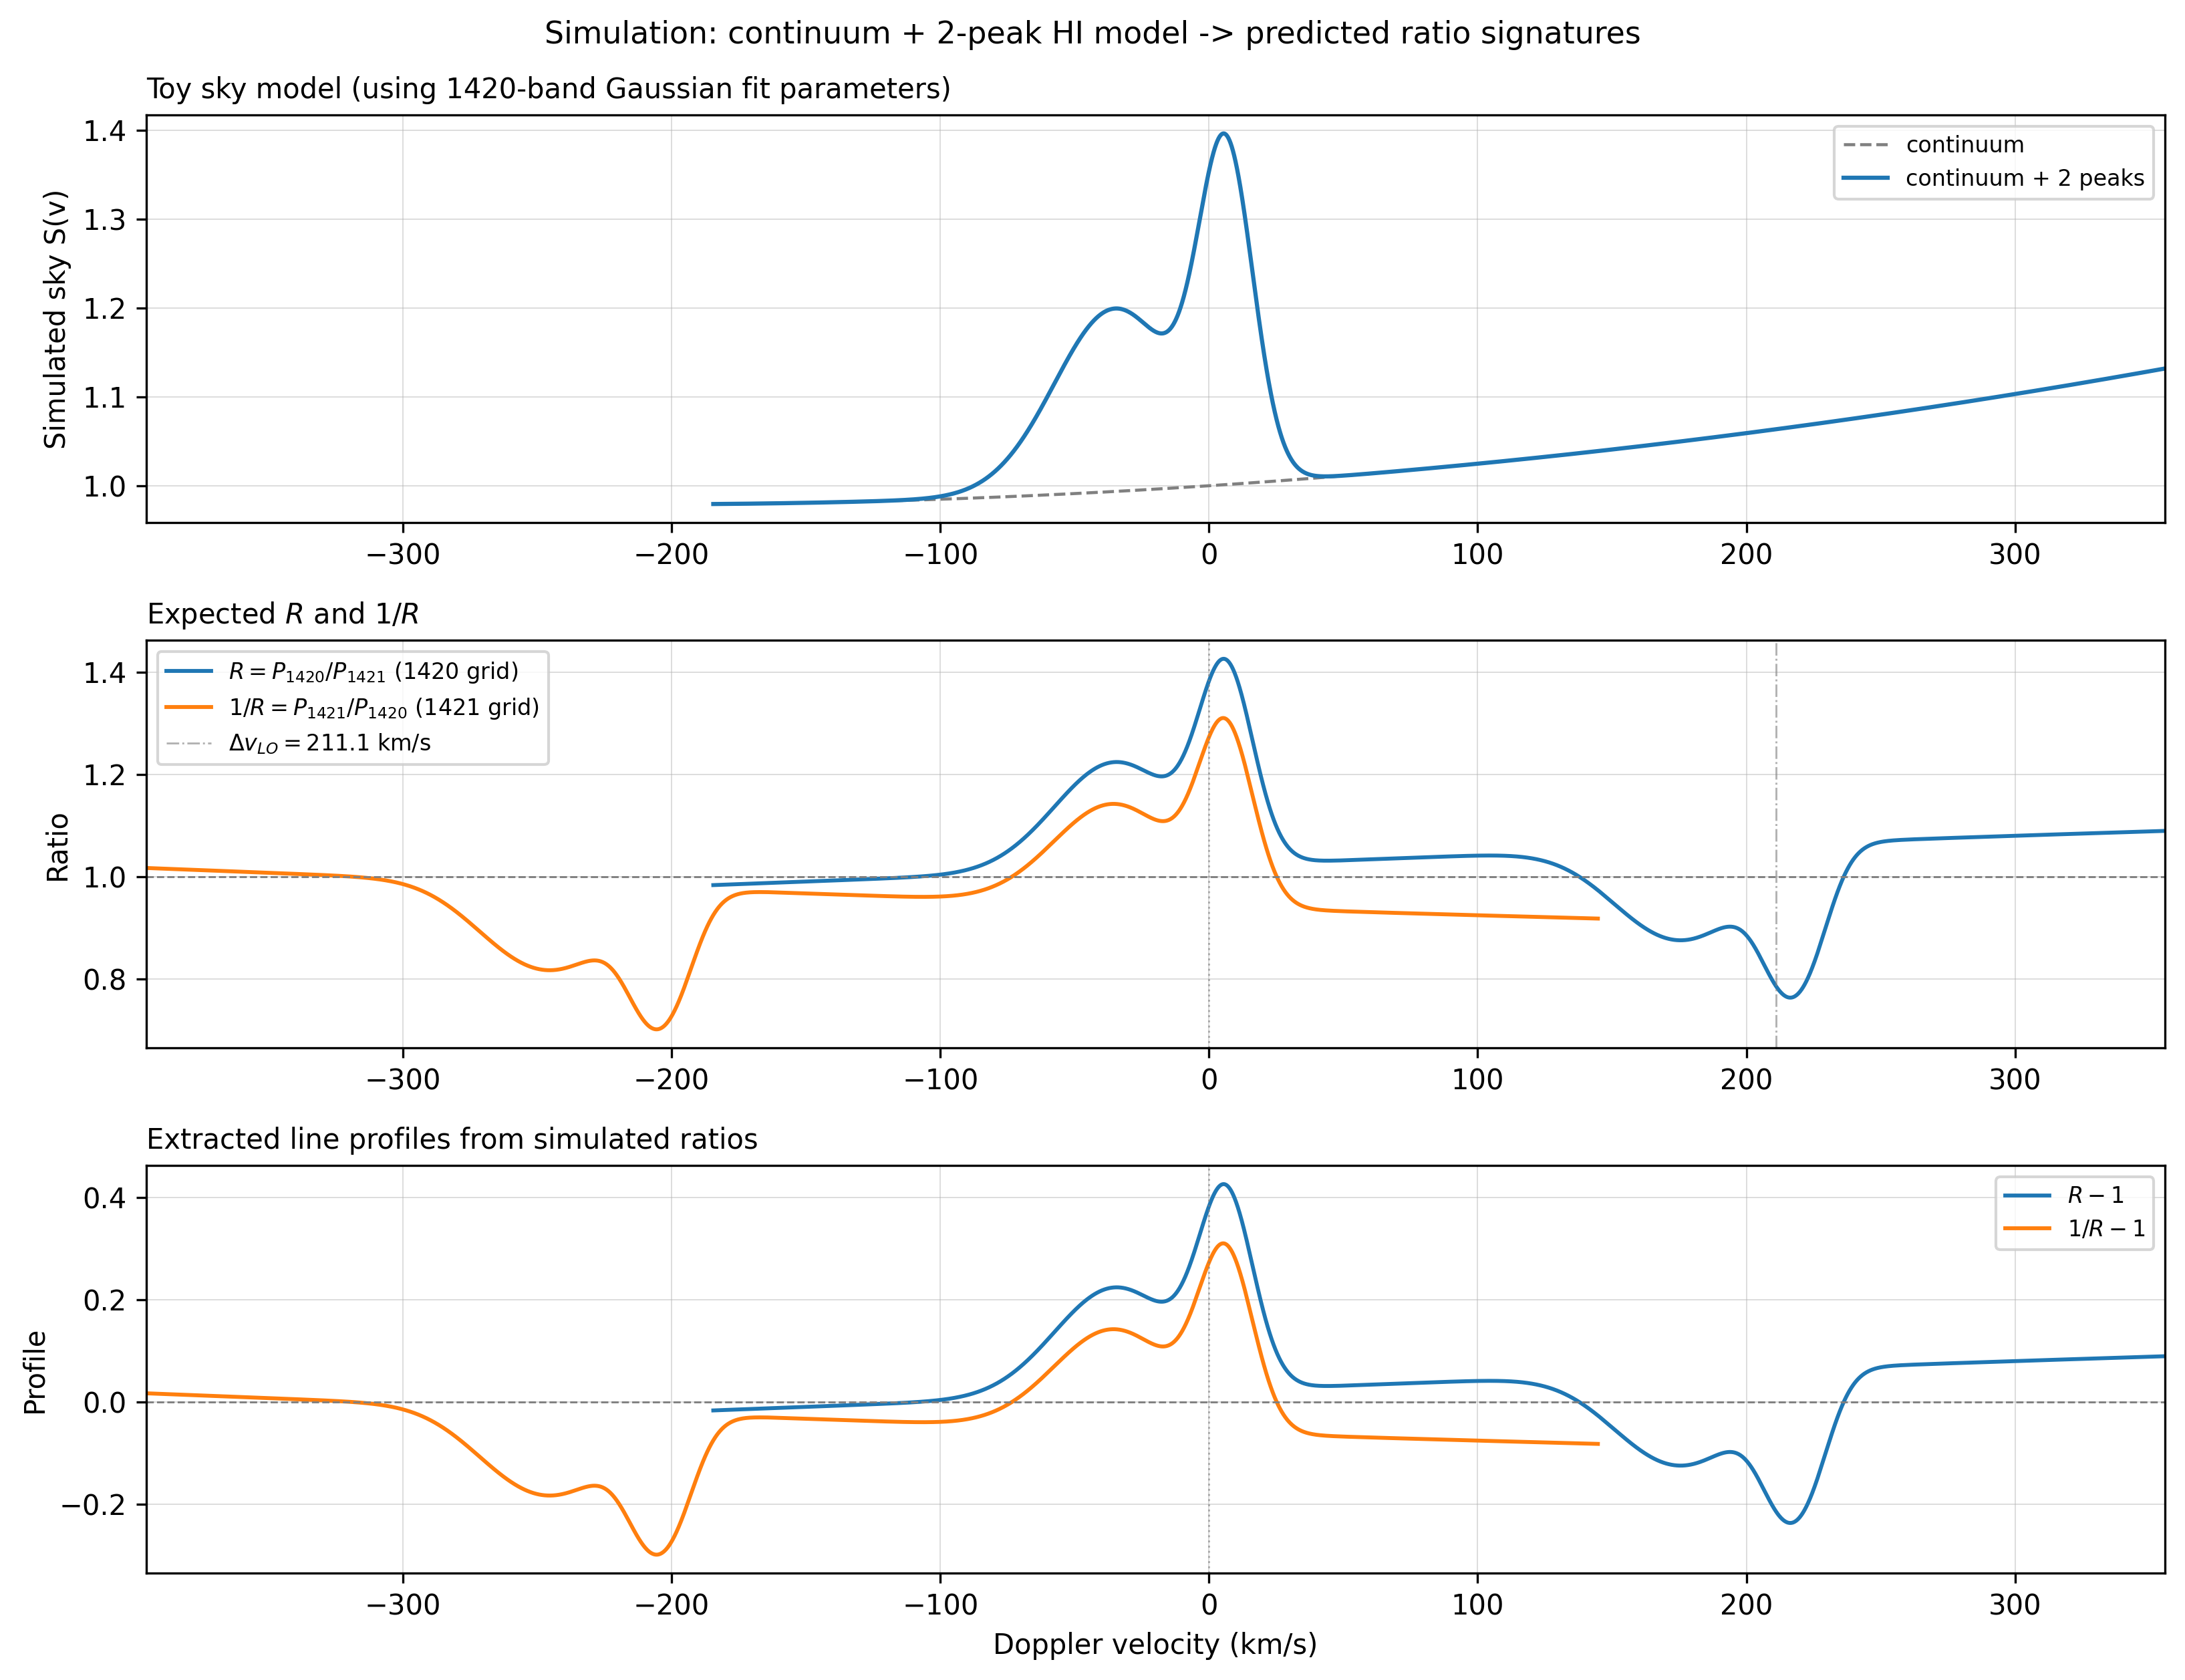

In [7]:
# Use fitted 1420-band components if available; otherwise fall back to current best-fit values.
if "popt_peak" in globals():
    sim_params_1420 = np.array(popt_peak[:6], dtype=float)
else:
    sim_params_1420 = np.array([0.35530, 6.33, 10.13, 0.20578, -34.99, 22.58], dtype=float)

A1, V1, S1, A2, V2, S2 = sim_params_1420

# Same baseband offsets as the real ratio construction
delta_f_hz = long_1420.freqs - long_1420.center_freq
f_sim_1420 = 1420e6 + delta_f_hz
f_sim_1421 = 1421e6 + delta_f_hz

C_LIGHT_KMS = 2.99792458e5

def sky_components(freq_hz):
    v = C_LIGHT_KMS * (HI_FREQ_HZ - freq_hz) / HI_FREQ_HZ
    # Smooth continuum + two HI peaks (from 1420-band fit)
    continuum = 1.0 + 0.05 * (v / 250.0) + 0.03 * (v / 250.0) ** 2
    line = multi_gaussian(v, *sim_params_1420)
    sky = continuum + line
    return v, continuum, line, sky

v1420_sim, cont1420, line1420, sky1420 = sky_components(f_sim_1420)
v1421_sim, cont1421, line1421, sky1421 = sky_components(f_sim_1421)

# Include an arbitrary common bandpass shape (cancels in the ratio)
x = delta_f_hz / np.max(np.abs(delta_f_hz))
bandpass = 1.0 - 0.30 * x**2 + 0.05 * x**4

P1420_sim = bandpass * sky1420
P1421_sim = bandpass * sky1421

with np.errstate(divide='ignore', invalid='ignore'):
    R_sim = P1420_sim / P1421_sim
    invR_sim = P1421_sim / P1420_sim

dnu_lo = 1421e6 - 1420e6
dv_lo = C_LIGHT_KMS * dnu_lo / HI_FREQ_HZ

fig, axes = plt.subplots(3, 1, figsize=(11, 8.5), dpi=300)

# Panel 1: toy sky model
ord0 = np.argsort(v1420_sim)
axes[0].plot(v1420_sim[ord0], cont1420[ord0], color='gray', ls='--', lw=1.1, label='continuum')
axes[0].plot(v1420_sim[ord0], sky1420[ord0], color='C0', lw=1.5, label='continuum + 2 peaks')
axes[0].set_ylabel('Simulated sky S(v)')
axes[0].set_title('Toy sky model (using 1420-band Gaussian fit parameters)', loc='left', fontsize=10)
axes[0].grid(True, lw=0.4, alpha=0.5)
axes[0].legend(fontsize=8)

# Panel 2: expected ratios
axes[1].plot(v1420_sim, R_sim, color='C0', lw=1.4, label=r'$R = P_{1420}/P_{1421}$ (1420 grid)')
axes[1].plot(v1421_sim, invR_sim, color='C1', lw=1.4, label=r'$1/R = P_{1421}/P_{1420}$ (1421 grid)')
axes[1].axhline(1.0, color='gray', lw=0.7, ls='--')
axes[1].axvline(0.0, color='gray', lw=0.7, ls=':', alpha=0.6)
axes[1].axvline(dv_lo, color='gray', lw=0.7, ls='-.', alpha=0.6, label=fr'$\Delta v_{{LO}}={dv_lo:.1f}$ km/s')
axes[1].set_ylabel('Ratio')
axes[1].set_title('Expected $R$ and $1/R$', loc='left', fontsize=10)
axes[1].grid(True, lw=0.4, alpha=0.5)
axes[1].legend(fontsize=8)

# Panel 3: baseline-subtracted forms
axes[2].plot(v1420_sim, R_sim - 1.0, color='C0', lw=1.4, label=r'$R-1$')
axes[2].plot(v1421_sim, invR_sim - 1.0, color='C1', lw=1.4, label=r'$1/R-1$')
axes[2].axhline(0.0, color='gray', lw=0.7, ls='--')
axes[2].axvline(0.0, color='gray', lw=0.7, ls=':', alpha=0.6)
axes[2].set_xlabel('Doppler velocity (km/s)')
axes[2].set_ylabel('Profile')
axes[2].set_title('Extracted line profiles from simulated ratios', loc='left', fontsize=10)
axes[2].grid(True, lw=0.4, alpha=0.5)
axes[2].legend(fontsize=8)

# Shared x-range for comparability
vmin = min(v1420_sim.min(), v1421_sim.min())
vmax = max(v1420_sim.max(), v1421_sim.max())
for ax in axes:
    ax.set_xlim(vmin, vmax)

fig.suptitle('Simulation: continuum + 2-peak HI model -> predicted ratio signatures', fontsize=11)
fig.tight_layout()
plt.show()
